In [1]:
import datetime
import glob
import logging
import os
import tarfile
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray

import G211

logging.basicConfig(format="%(asctime)s %(message)s", level=logging.INFO)
tmpdir = Path(os.getenv("TMPDIR"))

In [2]:
# Get lightning data from older tar file. Old tar files can be accessed /gpfs/csfs1/ral/aap/hardt/LTG directly, but
# recent tar files must be transfered with GLOBUS from https://app.globus.org/file-manager/collections "ENTLN lightning ascii files"
def getltg(valid_time, path=tmpdir, idir="/gpfs/csfs1/ral/aap/hardt/LTG"):
    ifile = os.path.join(
        idir,
        valid_time.strftime("%Y"),
        valid_time.strftime("%m%d"),
        valid_time.strftime("%Y%m%d_ENTLN_ascii_data.tar"),
    )
    tar = tarfile.open(ifile, mode="r")
    members = [os.path.join(path, x) for x in tar.getnames()]
    logging.info(f"extractall {len(members)} members from {ifile} ")
    ret = tar.extractall(path=path)
    return members

In [3]:
# Won't work on cheyenne. Doesn't see campaign storage.
members = getltg(pd.to_datetime("20180321"))

2024-09-20 10:23:05,920 extractall 1273 members from /gpfs/csfs1/ral/aap/hardt/LTG/2018/0321/20180321_ENTLN_ascii_data.tar 


In [4]:
idir = "/glade/campaign/mmm/parc/ahijevyc/ENTLN"

#### <code>gunzip -c *_ltg.asc.gz | grep f</code> into big text file and use <code>txt2par.py</code> to convert to parquet 

In [5]:
ls /glade/campaign/mmm/parc

access_report.txt*  chriss/    jban/      mpas-jedi/  schwartz/  vahl/
ahijevyc/           fossell/   jedipara/  mrislam/    sobash/    wuyl/
berner/             guerrett/  jwittig/   mwong/      sunj/      zhuming/
bjung/              hclin/     klupo/     nystrom/    syha/
chasteen/           ivette/    liuz/      romine/     taosun/


In [6]:
%%time
ifiles = glob.glob(os.path.join(idir, "flash20*.par"))

#ifiles = ifiles[0:8]  # UNCOMMENT FOR DEBUGGING
logging.info(f"{len(ifiles)} flash parquet files")
df = pd.concat([pd.read_parquet(x, engine="pyarrow") for x in ifiles]) # engine="pyarrow" 15% faster

2024-09-20 10:23:31,437 60 flash parquet files


CPU times: user 1min 11s, sys: 3min 38s, total: 4min 49s
Wall time: 29min 23s


In [7]:
df

,time,lat,lon,amp,incloud
14,2019-12-01 00:00:47.448,32.58713,-90.98580,-162.559,0
17,2019-12-01 00:00:48.048,34.98374,-85.64815,-2.538,1
18,2019-12-01 00:00:48.268,35.01637,-85.76471,-32.263,0
31,2019-12-01 00:00:47.929,32.72353,-91.02318,4.899,1
33,2019-12-01 00:00:48.904,35.09701,-85.82590,-17.057,1
...,...,...,...,...,...
45236492,2020-04-30 23:58:47.254,43.61216,-105.45859,3.248,1
45236494,2020-04-30 23:58:47.132,19.20217,-98.71252,5.453,1
45236497,2020-04-30 23:58:46.831,42.77410,-113.05863,-1.562,1
45236498,2020-04-30 23:58:46.972,26.29222,-76.08717,-1.050,1


<Axes: >

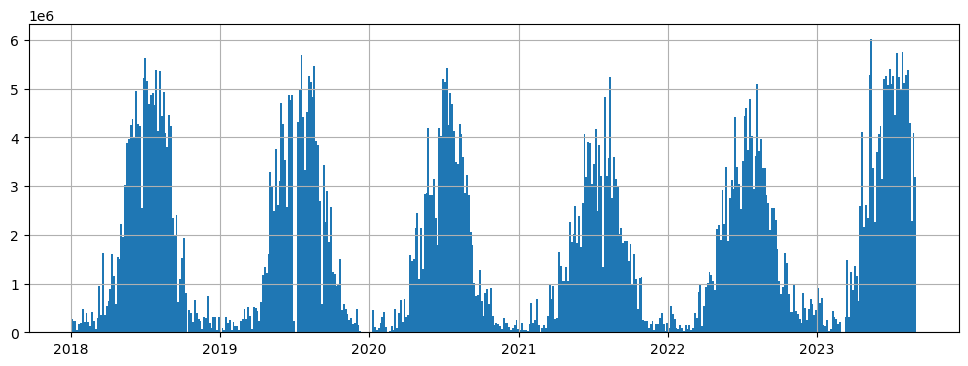

In [8]:
df.time.hist(bins=460, figsize=(12,4))

<Axes: >

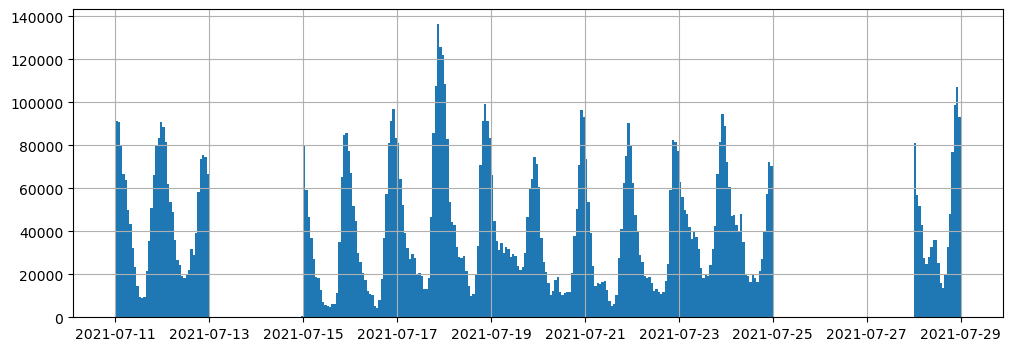

In [41]:
df.time[df.time.between(pd.to_datetime("20210711"), pd.to_datetime("20210729"))].hist(bins=360, figsize=(12,4))

In [13]:
time0 = pd.to_datetime("20180101")
past = df["time"] < time0
logging.warning(f"{past.sum()} ({past.sum()/len(df):%}) flashes before {time0}")
future = df["time"] >= datetime.datetime.utcnow()
logging.warning(f"{future.sum()} ({future.sum()/len(df):%}) flashes in future")
outofbounds = (
    (df["lat"] < 11) | (df["lat"] > 62) | (df["lon"] < -150) | (df["lon"] > -50)
)
logging.warning(
    f"{outofbounds.sum()} ({outofbounds.sum()/len(df):%}) flashes out-of-bounds"
)

df0 = df[~past & ~future & ~outofbounds]
df0

2024-08-28 16:57:24,574 0 (0.000000%) flashes before 2018-01-01 00:00:00
2024-08-28 16:57:27,537 0 (0.000000%) flashes in future
2024-08-28 16:57:40,662 0 (0.000000%) flashes out-of-bounds


,time,lat,lon,amp,incloud
14,2019-12-01 00:00:47.448,32.58713,-90.98580,-162.559,0
17,2019-12-01 00:00:48.048,34.98374,-85.64815,-2.538,1
18,2019-12-01 00:00:48.268,35.01637,-85.76471,-32.263,0
31,2019-12-01 00:00:47.929,32.72353,-91.02318,4.899,1
33,2019-12-01 00:00:48.904,35.09701,-85.82590,-17.057,1
...,...,...,...,...,...
45236492,2020-04-30 23:58:47.254,43.61216,-105.45859,3.248,1
45236494,2020-04-30 23:58:47.132,19.20217,-98.71252,5.453,1
45236497,2020-04-30 23:58:46.831,42.77410,-113.05863,-1.562,1
45236498,2020-04-30 23:58:46.972,26.29222,-76.08717,-1.050,1


In [ ]:
dfd = df0.set_index("time").sort_index()
dfd

In [ ]:
dfd.resample("30s").count()
# .rolling(window=2, center=False, closed="left").sum()

In [ ]:
dfd.resample("30s").count().rolling(window=2, step=2).sum()

In [ ]:
dfd.asfreq

In [ ]:
df0.plot.hexbin(x="lon", y="lat", figsize=(10, 7))

### flash.G211.nc was created separately by ENTLN_G211.py

In [17]:
ifile = os.path.join(idir, f"flash.40km_30min.nc")
ds = xarray.open_dataset(ifile)

<xarray.Dataset>
Dimensions:              (time_coverage_start: 94326, y: 65, x: 93)
Coordinates:
  * time_coverage_start  (time_coverage_start) datetime64[ns] 2018-01-01 ... ...
    lon                  (y, x) float64 ...
    lat                  (y, x) float64 ...
Dimensions without coordinates: y, x
Data variables:
    cg                   (time_coverage_start, y, x) float64 ...
    ic                   (time_coverage_start, y, x) float64 ...
Attributes:
    ellps:    WGS84
    proj:     lcc
    lon_0:    -95
    lat_0:    39.0
    x_0:      0.0
    y_0:      0.0
    lat_1:    25
    lat_2:    25

In [39]:
t = (ds.cg + ds.ic).sel(time_coverage_start = slice(pd.to_datetime("20210709"), pd.to_datetime("20210801"))).sum(dim=(["y","x"]))
t

<xarray.DataArray (time_coverage_start: 866)>
array([21844., 21749., 19205., 18711., 15891., 11534., 14012., 13178.,
       12580., 12958., 11345., 13994., 12301., 15385., 16284., 12972.,
       11722.,  8834.,  7977.,  7135.,  5615.,  5098.,  5380.,  4035.,
        4179.,  4285.,  4177.,  4204.,  4607.,  6203.,  5988.,  5920.,
        5809.,  7385., 10690., 12793., 17801., 21362., 24094., 25671.,
       29624., 31096., 33767., 34952., 35462., 35414., 36316., 38634.,
       36205., 31881., 36080., 38714., 39174., 42478., 45692., 43649.,
       40758., 37210., 33243., 28992., 24999., 23369., 21524., 21420.,
       20559., 21397., 18444., 16077., 11991.,  8111.,  7818.,  5629.,
        5398.,  6332.,  5986.,  5753.,  6512.,  8566.,  7818.,  6092.,
        7971.,  8870., 10223., 11046., 11391., 15663., 21976., 25358.,
       26398., 30245., 31000., 31360., 32670., 32914., 31206., 34106.,
       36885., 34821., 38070., 36121., 35013., 32171., 28533., 27970.,
       25586., 24564., 25118., 24518., 19489., 19954., 18516., 16237.,
       15429., 12989., 11235.,  8482.,  7097.,  6664.,  5485.,  4618.,
        3228.,  3385.,  3414.,  2761.,  3224.,  3285.,  3123.,  5010.,
        9187., 10666., 12768., 15872., 19652., 19552., 21083., 23797.,
       29540., 30157., 31947., 30580., 32832., 35741., 35380., 36335.,
       35625., 33162., 34880., 32528., 29184., 24621., 23080., 20422.,
       20700., 19709., 18613., 18558., 14505., 13558., 11346., 10241.,
...
       30364., 35275., 37864., 38240., 42467., 42822., 39778., 36376.,
       33207., 32655., 32741., 29697., 28084., 26167., 24074., 25517.,
       26114., 25880., 24812., 21386., 22482., 17349., 19222., 15295.,
       14234., 15018., 14350., 13998., 12400., 11777., 11184.,  9652.,
        9147.,  9271.,  9184.,  9450.,  6910.,  4971.,  4549.,  5758.,
        5914.,  5025.,  5638.,  5472.,  5137.,  6987., 12326., 18692.,
       23530., 29349., 33043., 37532., 41869., 43949., 41350., 46538.,
       45991., 47301., 46149., 42727., 37592., 33405., 29782., 29730.,
       28008., 27347., 23949., 23560., 27240., 25642., 24946., 24643.,
       24144., 20212., 22556., 21204., 17178., 15006., 14501., 15370.,
       13518., 11119., 10359.,  8564.,  6535.,  6418.,  6304.,  2835.,
        6952.,  8132.,  7077.,  6969.,  6167.,  7251., 11538., 15300.,
       18396., 26292., 30763., 37220., 38738., 40116., 41383., 38932.,
       35825., 37711., 35446., 28911., 28036., 30430., 30373., 27327.,
       24310., 23679., 25550., 24251., 23584., 18952., 17555., 16426.,
       14603., 12391., 11565., 12901., 12640., 11007., 10422.,  8252.,
        8799., 10010., 10031.,  9479.,  9488.,  7889.,  6114.,  6088.,
        6462.,  5377.,  4777.,  5975.,  8340., 13496., 18108., 24367.,
       29078., 33823., 36277., 44727., 46896., 45744., 47352., 49217.,
       51160., 47673.])
Coordinates:
  * time_coverage_start  (time_coverage_start) datetime64[ns] 2021-07-09 ... ...

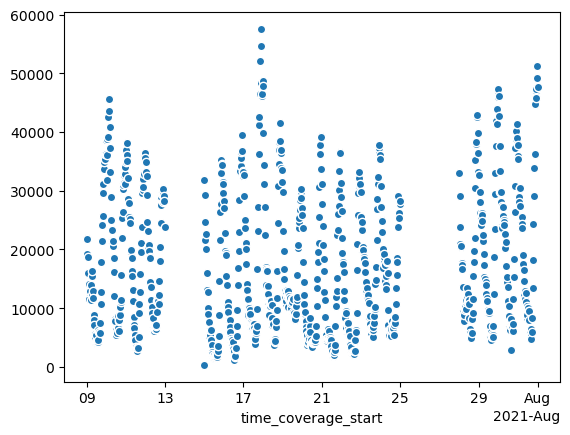

In [40]:
t.plot.scatter()

In [46]:
t.idxmin()

<xarray.DataArray 'time_coverage_start' ()>
array('2021-07-14T23:30:00.000000000', dtype='datetime64[ns]')

<Axes: ylabel='Count'>

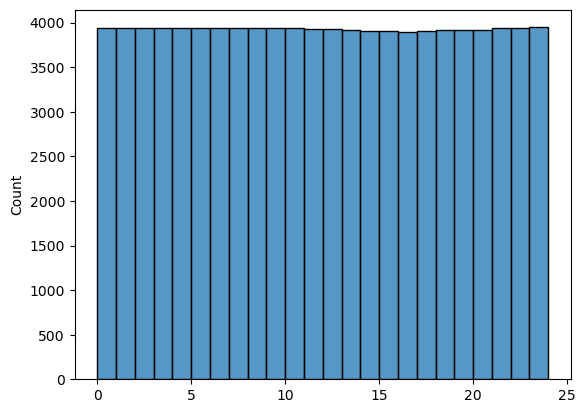

In [19]:
sns.histplot(ds.time_coverage_start.dt.hour, bins=range(25))

In [20]:
ds = ds.sel(time_coverage_start=slice("2020-06-20 00:00:00", "2020-06-20 00:00:00"))
ds

<xarray.Dataset>
Dimensions:              (time_coverage_start: 1, y: 65, x: 93)
Coordinates:
  * time_coverage_start  (time_coverage_start) datetime64[ns] 2020-06-20
    lon                  (y, x) float64 ...
    lat                  (y, x) float64 ...
Dimensions without coordinates: y, x
Data variables:
    cg                   (time_coverage_start, y, x) float64 ...
    ic                   (time_coverage_start, y, x) float64 ...
Attributes:
    ellps:    WGS84
    proj:     lcc
    lon_0:    -95
    lat_0:    39.0
    x_0:      0.0
    y_0:      0.0
    lat_1:    25
    lat_2:    25

In [21]:
ds.ic_hourly.sel(y=25, x=46).data

AttributeError: 'Dataset' object has no attribute 'ic_hourly'

In [ ]:
dd = ds.sum(dim=["y", "x"]).groupby(ds.time.dt.hour)

In [ ]:
ds.ic_hourly.sum(), ds.ic_hourly.max()

In [ ]:
fig, ax = plt.subplots(figsize=(16, 1))
sns.histplot(ds.time, bins=260, ax=ax)

In [ ]:
ds

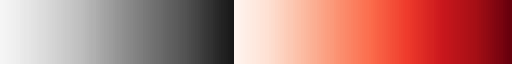

In [59]:
import cartopy.crs as ccrs
from matplotlib.colors import BoundaryNorm, ListedColormap

import nclcmaps
from statisticplot import make_map

cmap = plt.get_cmap("rainbow")

test = nclcmaps.colors["MPL_Greys"][10:-10:] + nclcmaps.colors["MPL_Reds"]
cmap = ListedColormap(test, "GreysReds")
norm = BoundaryNorm(np.arange(0, 28, 2), ncolors=cmap.N, clip=True)
cmap

## lightning longterm average

In [7]:
ifile = os.path.join("wbug_lightning", "flash_40km.nc")
logging.info(f"open wbug {ifile}")
wb = xarray.open_dataset(ifile)
times = wb.time_coverage_start.values
logging.info(f"average {times.size} times")
wb = wb.mean(dim="time_coverage_start")
logging.info("done")

2023-06-06 15:53:02,200 open wbug wbug_lightning/flash_40km.nc
2023-06-06 15:53:03,037 average 83495 times
2023-06-06 15:53:30,071 done


In [62]:
assert times[1] - times[0] == pd.Timedelta(minutes=30)
# multiply by two because time blocks were 30-minutes and we want flashes per hour
wb["total flashes"] = xarray.DataArray(
    2 * (wb.cg + wb.ic), attrs=dict(long_name="cg & ic flashes per hour")
)

Text(0.5, 1.0, '2018-01-01T00:00:00.000000000 - 2022-12-31T23:30:00.000000000')

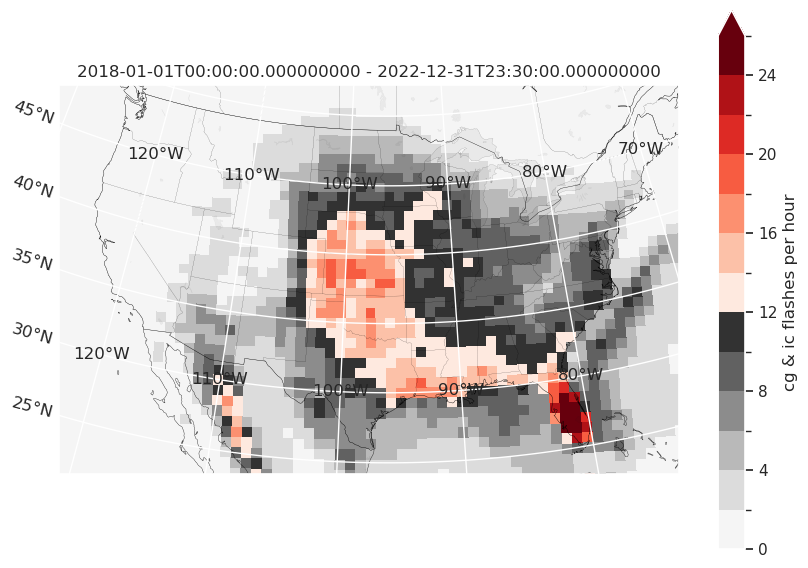

In [60]:
fig, ax = make_map()

sc = wb["total flashes"].plot(
    x="lon", y="lat", cmap=cmap, transform=ccrs.PlateCarree(), norm=norm
)
ax.set_title(f"{times.min()} - {times.max()}")

In [15]:
del ds.attrs["history"]

NameError: name 'ds' is not defined

2023-06-06 16:24:36,596 20180213T1830
2023-06-06 16:24:36,603 20180213T1730


Text(0.5, 1.0, '20180213T1730 - 20221231T2330')

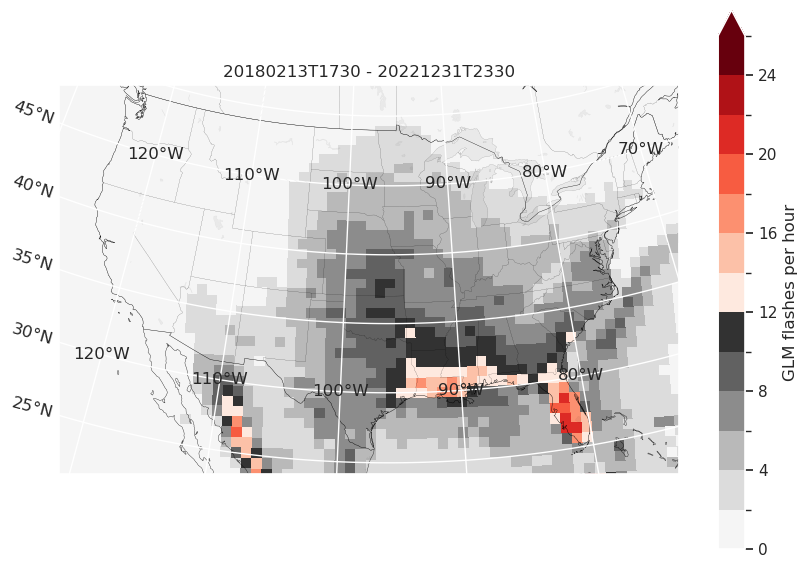

In [61]:
ifile = "GLM/longterm_average.glm.nc"
ds = xarray.open_dataset(ifile)
fig, ax = make_map()
ifiles = ds.attrs["history"].replace("_", "T").split()[8:-1]
logging.info(ifiles[1][5:-7])
logging.info(ifiles[0][5:-7])
assert pd.to_datetime(ifiles[1][5:-7]) - pd.to_datetime(
    ifiles[0][5:-7]
) == pd.Timedelta(hours=1)
time_range = " - ".join([ifiles[0][5:-7], ifiles[-1][5:-7]])
ds["flashes"] = xarray.DataArray(
    ds["flashes"], attrs=dict(long_name="GLM flashes per hour")
)
sc = ds["flashes"].plot(
    x="lon", y="lat", cmap=cmap, transform=ccrs.PlateCarree(), ax=ax, norm=norm
)
ax.set_title(time_range)

In [10]:
ifiles = ds.attrs["history"].split()[8:-1]
print(ifiles[0], ifiles[-1])

2018/20180213_1730.glm.nc 2022/20221231_2330.glm.nc
